## Starter Code

<span style="color:blue">**In this guide, we provide a starter code to help you begin your project.
Please feel free to use it thoughtfully and tailor it to your specific requirements.**</span>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset

**Facial Recognition**

Dataset: FER2013
- CSV Format: Kaggle Link https://www.kaggle.com/datasets/nicolejyt/facialexpressionrecognition
- JPG Format: Kaggle Link https://www.kaggle.com/datasets/msambare/fer2013/data
- Details:
    - 34,034 images
    - 48x48 pixels
    - 7 emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral

**Gesture Recognition**

Dataset: LeapGestureRecognition

- Download Link: Kaggle https://www.kaggle.com/datasets/gti-upm/leapgestrecog
- Other Gesture Dataset: GitHub https://github.com/linto-ai/multi-hand-gesture-dataset

### Examples & Inspirations:

#### Facial Expression

1. Static and dynamic facial emotion recognition using the Emo-AffectNet

   https://huggingface.co/ElenaRyumina/face_emotion_recognition


   ![example](https://github.com/ElenaRyumina/EMO-AffectNetModel/blob/main/gif/result_2.gif?raw=true)


2. Facial Expression Recognition Challenge

   https://github.com/chinhau-lim/fer_2013

#### Hand Gesture

1. Real-time hand gesture recognition using TensorFlow & OpenCV

   https://techvidvan.com/tutorials/hand-gesture-recognition-tensorflow-opencv/

    ![example](https://techvidvan.com/tutorials/wp-content/uploads/sites/2/2021/07/landmark-output.gif)



2. Deep_learning_hand_gesture_recognition

   https://github.com/guillaumephd/deep_learning_hand_gesture_recognition

In [ ]:
# Install required packages
# !pip3 install opencv-python numpy pandas tensorflow scikit-learn

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


### 1. Data Preparation

In [11]:
# Facial Emotion Classes
EMOTION_MAP = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Gesture Classes (LeapGestRecog)
GESTURE_MAP = {
    0: 'palm',        # 01_palm
    1: 'l',           # 02_l
    2: 'fist',        # 03_fist
    3: 'fist_moved',  # 04_fist_moved
    4: 'thumb',       # 05_thumb
    5: 'index',       # 06_index
    6: 'ok',          # 07_ok
    7: 'palm_moved',  # 08_palm_moved
    8: 'c',           # 09_c
    9: 'down'         # 10_down
}

def load_fer2013(file_path='/content/drive/MyDrive/Prototype Emotive Avatar Data/fer2013.csv'):
    """Loads and balances FER2013 dataset"""
    df = pd.read_csv(file_path)
    pixels = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
    images = np.array([x.reshape(48, 48, 1) for x in pixels]) / 255.0
    labels = df['emotion'].values

    # Handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return images, labels, dict(enumerate(class_weights))

def load_leap_gestures(dataset_path="/content/drive/MyDrive/Prototype Emotive Avatar Data/leapGestRecog"):
    """Loads Leap Motion dataset with correct label mapping"""
    X, y = [], []

    for root, _, files in os.walk(dataset_path):
        try:
            folder_name = os.path.basename(root)
            if not folder_name[:2].isdigit():
                continue

            gesture_num = int(folder_name[:2]) - 1
            if gesture_num not in GESTURE_MAP:
                continue

            # Process images
            for file in files:
                if file.endswith(".png"):
                    img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (64, 64))
                    X.append(img.astype('float32') / 255.0)
                    y.append(gesture_num)

        except Exception as e:
            print(f"Skipping {root}: {str(e)}")

    return np.array(X).reshape(-1, 64, 64, 1), np.array(y)

### 2. Model Architecture

In [18]:
class EmotiveAvatarSystem:
    def __init__(self):
        self.face_model = self.build_face_model()
        self.gesture_model = self.build_gesture_model()

    def build_face_model(self):
        resize_and_rescale = models.Sequential([
            layers.Resizing(48, 48),
            layers.Rescaling(1./255)
        ])

        data_augmentation = models.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomBrightness(.2),
            layers.RandomContrast(.2),
        ])

        model = models.Sequential([
            resize_and_rescale,
            data_augmentation,
            layers.Conv2D(16, (3,3), activation='relu', padding='same'),
            layers.MaxPool2D((2, 2)),

            layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.3),

            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.4),

            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(7, activation='softmax')
        ])

        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        return model


    def build_gesture_model(self):
        model = models.Sequential([
            layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,1)),
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.25),

            layers.Conv2D(32, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.35),

            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])

        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        return model

### 3. Training & Evaluation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Facial Model (FER2013)...
Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1186 - loss: 2.0641 - val_accuracy: 0.1122 - val_loss: 1.9457 - learning_rate: 0.0010
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1256 - loss: 1.9537 - val_accuracy: 0.2440 - val_loss: 1.9454 - learning_rate: 0.0010
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2050 - loss: 1.9083 - val_accuracy: 0.0150 - val_loss: 1.9471 - learning_rate: 0.0010
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0793 - loss: 1.9517 - val_accuracy: 0.2440 - val_loss: 1.9466 - learning_rate: 0.0010
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1370 - loss: 1.9514 - val_accuracy: 0.2440 - val_loss: 1.9463 - learning_rate: 5.0000e-04


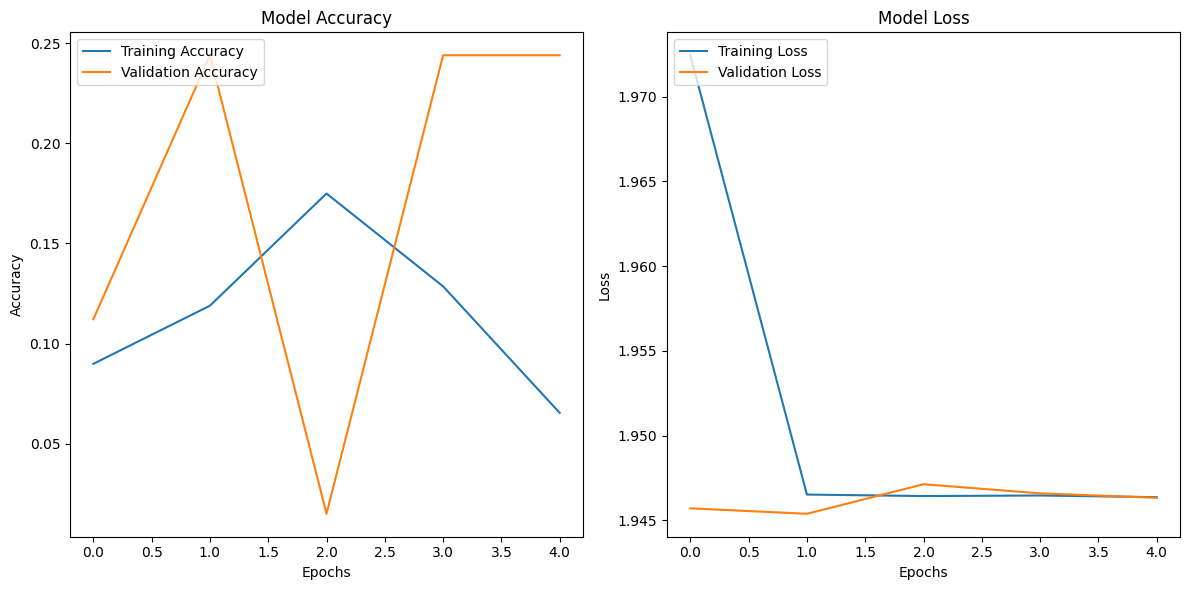

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2488 - loss: 1.9454

=== Final Performance ===
Facial Accuracy: 25.05%


In [26]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    X_face, y_face, face_weights = load_fer2013()
    #X_gesture, y_gesture = load_leap_gestures()

    # Split datasets
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_face, y_face, test_size=0.2, stratify=y_face)
    #Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_gesture, y_gesture, test_size=0.2, stratify=y_gesture)

    # Initialize system
    avatar = EmotiveAvatarSystem()

    # Train facial model
    print("Training Facial Model (FER2013)...")
    history = avatar.face_model.fit(Xf_train, yf_train,
                                    epochs=5,
                                    batch_size=64,
                                    class_weight=face_weights,
                                    validation_split=0.2,
                                    verbose=1,
                                    callbacks=[
                                        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                                        callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
                                    ])

    # Plotting accuracy and loss curves
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # Evaluate
    f_loss, f_acc = avatar.face_model.evaluate(Xf_test, yf_test)
   # g_loss, g_acc = avatar.gesture_model.evaluate(Xg_test, yg_test)

    print("\n=== Final Performance ===")
    print(f"Facial Accuracy: {f_acc:.2%}")
    #print(f"Gesture Accuracy: {g_acc:.2%}")


### Improvement Opportunities:
1. Add real-time webcam integration
2. Implement data augmentation for infrared images
4. Add attention mechanisms to the CNN
5. ......

Reference:

https://github.com/chinhau-lim/fer_2013

https://arxiv.org/pdf/2105.03588

https://github.com/takanto/FER2013

https://aicompetence.org/ai-in-cultural-sensitivity-gesture-interpretation/


# Website Display

### 1. Website Requirements

In [ ]:
# !pip install pyngrok

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `ngrok authtoken userdata.get('ngrok-api-key')'


### 2. Website Display

In [22]:
from google.colab import userdata
from pyngrok import ngrok

# Retrieve the ngrok API key from Google Secrets
ngrok_api_key = userdata.get('ngrok-api-key')

# Check if the API key was retrieved successfully
print(f"API Key retrieved: {ngrok_api_key}")

# Authenticate ngrok with the API key
ngrok.set_auth_token(ngrok_api_key)

# Set up a simple Flask app
from flask import Flask

app = Flask(__name__)

@app.route("/")
def home():
    return "Hello from Flask with ngrok on Google Colab!"

# Open a ngrok tunnel to the Flask app
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> http://127.0.0.1:5000")

# Run the Flask app
app.run(port=5000)

ModuleNotFoundError: No module named 'pyngrok'